In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
import logging
import sys
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer




In [2]:
def fill_na_values(df):
    """
    Fill missing values in a dataframe using different imputation strategies.
    
    Args:
        df: DataFrame with missing values
        
    Returns:
        DataFrame with imputed values
    """
    # Make a copy to avoid modifying the original
    df_copy = df.copy()
    
    numerical_cols = df_copy.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    print(f"{categorical_cols = }")
    
    # 1. For numerical columns - use median imputation
    if numerical_cols:
        simple_imputer = SimpleImputer(strategy='median')
        df_copy[numerical_cols] = simple_imputer.fit_transform(df_copy[numerical_cols])
    
    # 2. For categorical columns - use mode imputation
    if categorical_cols:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df_copy[categorical_cols] = cat_imputer.fit_transform(df_copy[categorical_cols])
        
    return df_copy

def preprocess_data(X):
    """
    Preprocess features for model training.
    
    Args:
        X: DataFrame of features
        
    Returns:
        DataFrame of preprocessed features
    """
    logging.info("Preprocessing features...")
    # Make a copy to avoid modifying the original
    X_copy = X.copy()
    
    # Convert datetime columns to ordinal
    for col in X_copy.select_dtypes(include=['datetime64']).columns:
        X_copy[col] = X_copy[col].apply(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    
    # Encode object columns
    for col in X_copy.select_dtypes(include=['object']).columns:
        X_copy[col] = LabelEncoder().fit_transform(X_copy[col].astype(str))
    
    # Impute missing values
    imputer = SimpleImputer(strategy="mean")
    X_imputed = pd.DataFrame(imputer.fit_transform(X_copy), columns=X_copy.columns)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_copy.columns)
    
    return X_scaled

def preprocess_labels(y_classification):
    """
    Preprocess classification labels.
    
    Args:
        y_classification: DataFrame of classification labels
        
    Returns:
        DataFrame of preprocessed labels
    """
    # Make a copy to avoid modifying the original
    y_copy = y_classification.copy()
    
    for col in y_copy.columns:
        if y_copy[col].dtype in ['float64', 'int64']:
            y_copy[col] = pd.cut(y_copy[col], bins=[-np.inf, 0, np.inf], labels=[0, 1])
        y_copy[col] = LabelEncoder().fit_transform(y_copy[col].astype(str))
    
    # Fill NA values with mode (properly without inplace)
    mode_values = y_copy.mode().iloc[0]
    for col in y_copy.columns:
        y_copy[col] = y_copy[col].fillna(mode_values[col])
    
    # Keep only columns with more than one unique value
    y_filtered = y_copy.loc[:, y_copy.nunique() > 1]
    
    return y_filtered

def preprocess_regression_labels(y_regression):
    """
    Preprocess regression labels.
    
    Args:
        y_regression: DataFrame of regression labels
        
    Returns:
        DataFrame of preprocessed labels
    """
    # Make a copy to avoid modifying the original
    y_copy = y_regression.copy()
    
    for col in y_copy.columns:
        # Convert to numeric
        y_copy[col] = pd.to_numeric(y_copy[col], errors='coerce')
        
        # Fill NaN values with median (properly without inplace)
        median_val = y_copy[col].median()
        y_copy[col] = y_copy[col].fillna(median_val)
    
    return y_copy

# Advanced version of fill_na_values using MICE
def fill_na_values_advanced(df):
    """
    Advanced missing value imputation using multiple techniques.
    
    Args:
        df: DataFrame with missing values
        
    Returns:
        DataFrame with imputed values
    """
    # Make a copy to avoid modifying the original
    df_copy = df.copy()
    
    numerical_cols = df_copy.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # For numerical columns with complex relationships, use MICE
    if numerical_cols:
        # Check if there are any missing values
        if df_copy[numerical_cols].isnull().any().any():
            mice_imputer = IterativeImputer(max_iter=10, random_state=0)
            df_copy[numerical_cols] = pd.DataFrame(
                mice_imputer.fit_transform(df_copy[numerical_cols]),
                columns=numerical_cols,
                index=df_copy.index
            )
    
    # For categorical columns
    if categorical_cols:
        for col in categorical_cols:
            # Fill with most frequent value
            most_frequent = df_copy[col].mode()[0]
            df_copy[col] = df_copy[col].fillna(most_frequent)
    
    return df_copy

In [3]:
# Read dataframe
df = pd.read_csv("preprocessed_ml_for_aml_mds.csv")

# Now we want to generate new feature from our current column
# We're gonna answer the following question:
# Tier 1 Can dynamic changes of the CD3 positive (CD3+) chimerism at
# Day 30, 60 and 100 (ie. An upward trend from Day 30 to 100, an increase
# from Day 30 to 60 but dropping at Day 100, an increase by 20% from Day 30 to Day 100 
# etc) predict allogeneic stem cell transplant outcomes, particularly disease relapse?


# First, we'll calculate the difference between 30 - 60, then 60-100.
df["d(30-60)_cd3+"] = df["d30_cd3+"] - df["d60_cd3+"]
df["d(60-100)_cd3+"] = df["d60_cd3+"] - df["d100_cd3+"]

df["d(30-60)_cd3-"] = df["d30_cd3-"] - df["d60_cd3-"]
df["d(60-100)_cd3-"] = df["d60_cd3-"] - df["d100_cd3-"]

# plot box plot

def handle_chimerisms(x):
    if x < 0:
        return -1

    elif x == 0:
        return 0

    else:
        return 1

# df["d(30-60)_cd3+"] = df["d(30-60)_cd3+"].apply(func= lambda x: handle_chimerisms(x))
# df["d(30-60)_cd3-"] = df["d(30-60)_cd3-"].apply(func= lambda x: handle_chimerisms(x))
# df["d(60-100)_cd3+"] = df["d(60-100)_cd3+"].apply(func= lambda x: handle_chimerisms(x))
# df["d(60-100)_cd3-"] = df["d(60-100)_cd3-"].apply(func= lambda x: handle_chimerisms(x))

# print(df.head())
# print("\n")

# age & donor age ratio
df["age_reciever_donor_ratio"] = df["age"] / df["donor_age"]

df["mean_ch+"] = df[["d30_cd3+", "d60_cd3+", "d100_cd3+"]].mean(axis=1)
df["mean_ch-"] = df[["d30_cd3-", "d60_cd3-", "d100_cd3-"]].mean(axis=1)

df["std_ch+"] = df[["d30_cd3+", "d60_cd3+", "d100_cd3+"]].std(axis=1)
df["std_ch-"] = df[["d30_cd3-", "d60_cd3-", "d100_cd3-"]].std(axis=1)

df["cv_ch+"] = df["std_ch+"] / df["mean_ch+"]
df["cv_ch-"] = df["std_ch-"] / df["mean_ch-"]


df.head()

,age,disease,disease_risk_index,hct_ci_score,time_from_diagnosis_to_alloSCT,aml_eln_risk_category,disease_state_at_transplant,mrd_status_prior_to_transplant,donor_type,cd34+_dose,...,d(60-100)_cd3+,d(30-60)_cd3-,d(60-100)_cd3-,age_reciever_donor_ratio,mean_ch+,mean_ch-,std_ch+,std_ch-,cv_ch+,cv_ch-
0,61,2,3,2,253.0,NaN,NaN,NaN,2,5.40,...,6.0,-3.0,-9.0,2.652174,91.666667,93.000000,5.033223,6.244998,0.054908,0.067151
1,53,5,2,0,218.0,NaN,NaN,NaN,2,5.04,...,0.0,1.0,-1.0,1.892857,96.000000,99.666667,0.000000,0.577350,0.000000,0.005793
2,63,1,2,0,162.0,3.0,1.0,1.0,1,4.66,...,2.0,0.0,0.0,1.016129,97.666667,100.000000,1.527525,0.000000,0.015640,0.000000
3,53,1,2,1,105.0,2.0,1.0,1.0,3,4.80,...,NaN,NaN,NaN,1.962963,100.000000,100.000000,NaN,NaN,NaN,NaN
4,52,2,2,8,238.0,NaN,NaN,NaN,2,3.00,...,NaN,NaN,NaN,1.181818,99.000000,100.000000,NaN,NaN,NaN,NaN


In [4]:
# Define feature and label columns
df = df[df["disease"] == 1]

# Fill NaN Values based on above explaination
feature_cols = [col for col in df.columns if not col.startswith("y_")]
print(f"{len(feature_cols) = }")
for col in feature_cols[:]:
    if col.strip() in ["dose_dli", "dose_dli_2","indication_for_dli", "post_dli_gvhd", "grade_at_onset", "time_to_onset", "highest_grade", "dli", "aml_eln_risk_category", "disease_risk_index", "time_from_diagnosis_to_alloSCT", "hct_ci_score"]:
        feature_cols.remove(col)

print(f"{'time_to_onset' in feature_cols = }")
print(f"{len(feature_cols) = }")

regression_labels = ["y_os_days", "y_rfs_days"]
classification_labels = [col for col in df.columns if col.startswith("y_") and (not col in regression_labels)]

print(f"{len(classification_labels) = }")
for col in classification_labels[:]:
    if len(df[col].dropna()) != len(df):
        classification_labels.remove(col)

print(f"{len(classification_labels) = }")
print(f"{classification_labels = }")
print(f"{regression_labels = }")

df.dropna(subset=["d100_cd3+"], inplace = True)

X = df[feature_cols].copy()
y_classification = df[classification_labels].copy()
y_regression = df[regression_labels].copy()
X = fill_na_values(X)
X.reset_index(drop=True, inplace=True)
y_classification.reset_index(drop=True, inplace=True)
y_regression.reset_index(drop=True, inplace=True)

X_preprocessed = preprocess_data(X)
y_classification = preprocess_labels(y_classification)
# y_classification = pd.DataFrame(y_classification["y_relapse"], columns=["y_relapse"])
y_regression = preprocess_regression_labels(y_regression)

len(feature_cols) = 58
'time_to_onset' in feature_cols = False
len(feature_cols) = 46
len(classification_labels) = 15
len(classification_labels) = 5
classification_labels = ['y_rfs', 'y_death', 'y_relapse', 'y_cgvhd', 'y_agvhd']
regression_labels = ['y_os_days', 'y_rfs_days']
categorical_cols = ['degree_of_match', 'conditioning_regimen', 'neutrophil_engraftment', 'platelet_engraftment']


In [5]:
X_preprocessed.head()

,age,disease,disease_state_at_transplant,mrd_status_prior_to_transplant,donor_type,cd34+_dose,donor_age,hla_matched_mismatched,degree_of_match,mac_or_ric,...,d(60-100)_cd3+,d(30-60)_cd3-,d(60-100)_cd3-,age_reciever_donor_ratio,mean_ch+,mean_ch-,std_ch+,std_ch-,cv_ch+,cv_ch-
0,0.855494,0.0,-0.541098,0.317311,-1.086880,-0.515823,1.374954,-0.525759,0.953328,0.736925,...,0.013313,-0.113793,-0.159711,-0.611396,0.435639,0.292318,-0.364185,-0.268116,-0.354942,-0.238220
1,1.338344,0.0,-0.541098,-0.789751,-1.086880,-0.380978,1.235684,-0.525759,0.953328,-1.224044,...,0.013313,-0.113793,-0.159711,-0.383749,0.261447,0.292318,-0.403625,-0.268116,-0.375921,-0.238220
2,-0.110204,0.0,-0.541098,-0.789751,0.371583,-0.188342,-1.619341,-0.525759,1.957841,-1.224044,...,-0.126033,-0.113793,-0.159711,2.225165,0.609831,0.292318,-0.525778,-0.268116,-0.447945,-0.238220
3,-0.593054,0.0,1.061777,-0.789751,-1.086880,-0.188342,-0.017741,-0.525759,0.953328,-1.224044,...,-0.404725,-0.113793,-0.159711,-0.517360,-0.086938,0.292318,-0.281473,-0.268116,-0.296482,-0.238220
4,0.050745,0.0,-0.541098,0.317311,1.830046,-0.188342,0.469702,1.902011,-0.051185,-1.224044,...,-0.335052,-0.485989,-0.159711,-0.500008,0.435639,0.221439,-0.305564,-0.171645,-0.321204,-0.169359


In [6]:
y_classification

,y_rfs,y_death,y_relapse,y_cgvhd,y_agvhd
0,1,1,1,0,1
1,1,1,1,0,0
2,0,0,0,1,1
3,0,0,0,0,1
4,0,0,0,0,0
...,...,...,...,...,...
152,1,1,0,1,1
153,0,0,0,1,0
154,0,0,0,1,0
155,1,1,1,0,0




Analyzing label: y_rfs
Class distribution: {0: np.int64(85), 1: np.int64(72)}


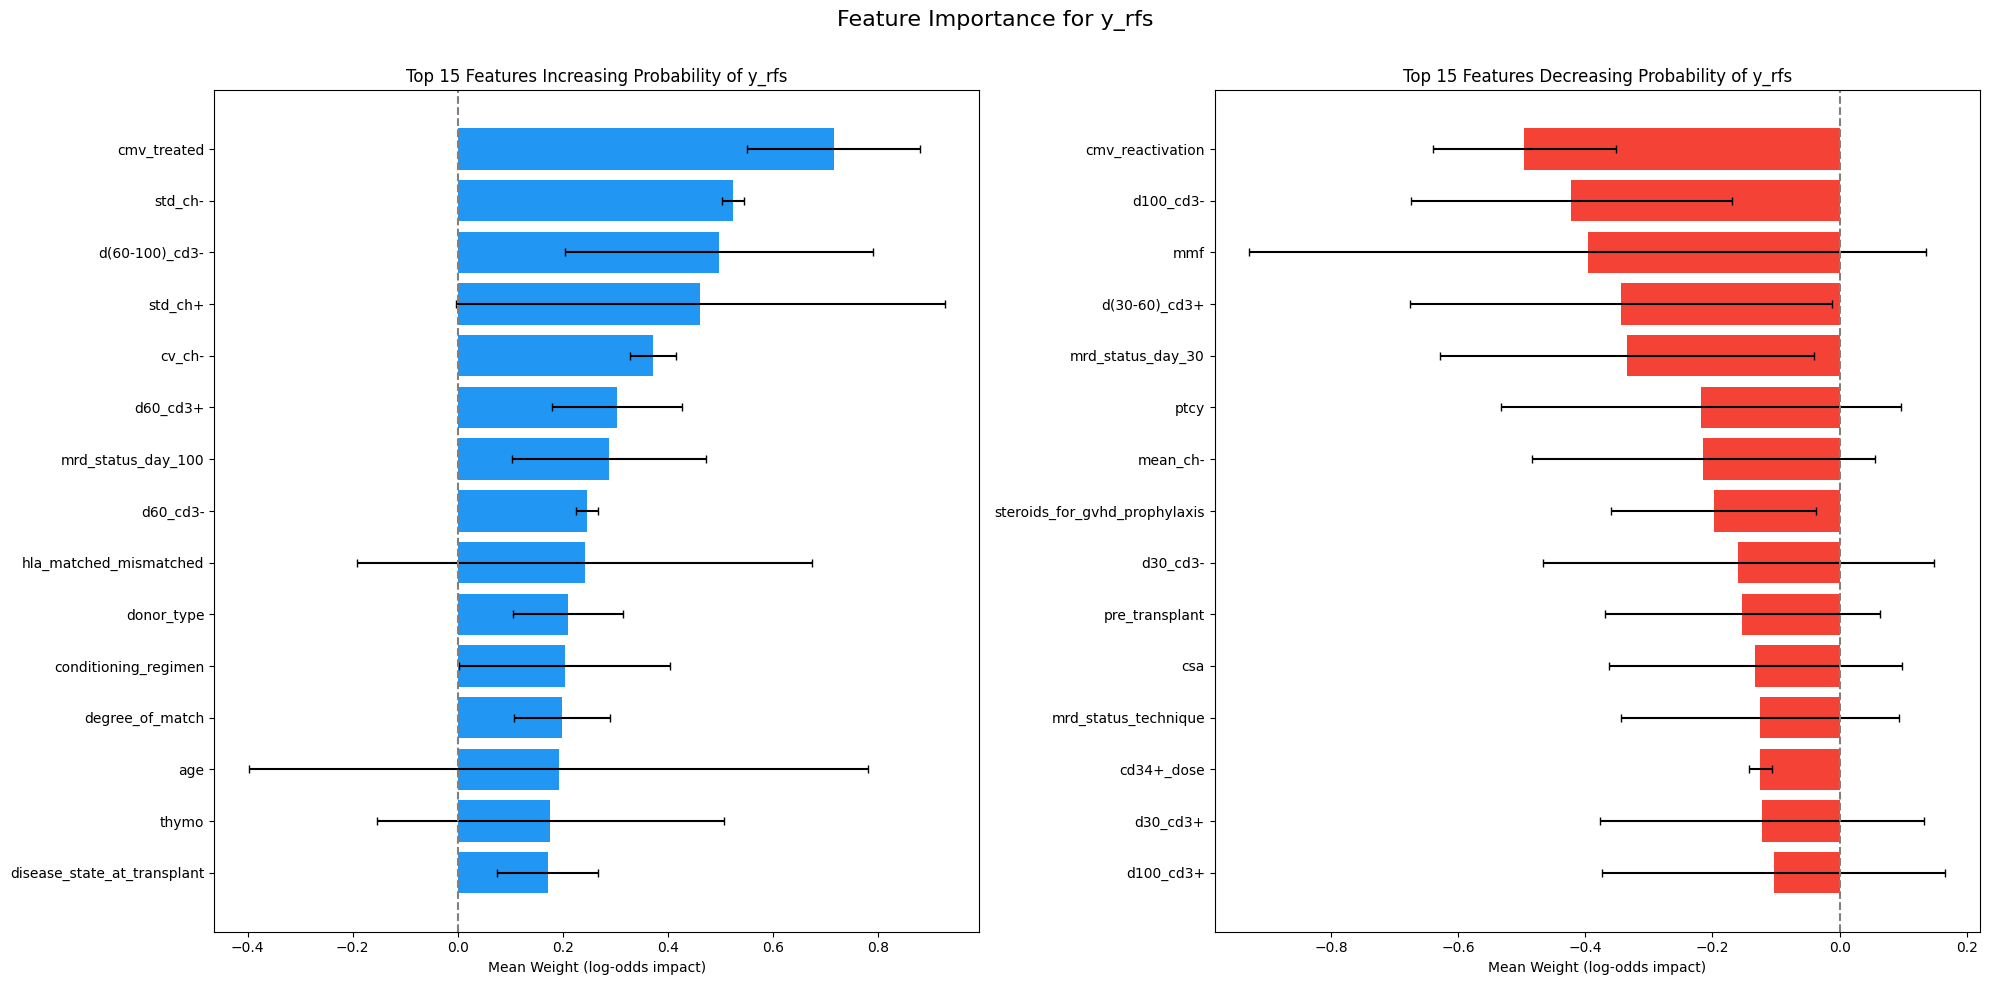


Top 10 most important features:
                                       Feature  Mean Weight
cmv_treated                        cmv_treated     0.716750
std_ch-                                std_ch-     0.524958
d(60-100)_cd3-                  d(60-100)_cd3-     0.497337
std_ch+                                std_ch+     0.462015
cv_ch-                                  cv_ch-     0.371882
d60_cd3+                              d60_cd3+     0.303399
mrd_status_day_100          mrd_status_day_100     0.288748
d60_cd3-                              d60_cd3-     0.246759
hla_matched_mismatched  hla_matched_mismatched     0.241668
donor_type                          donor_type     0.210498

Top 10 least important features:
                                                     Feature  Mean Weight
pre_transplant                                pre_transplant    -0.153129
d30_cd3-                                            d30_cd3-    -0.159368
steroids_for_gvhd_prophylaxis  steroids_for_gvhd_pr

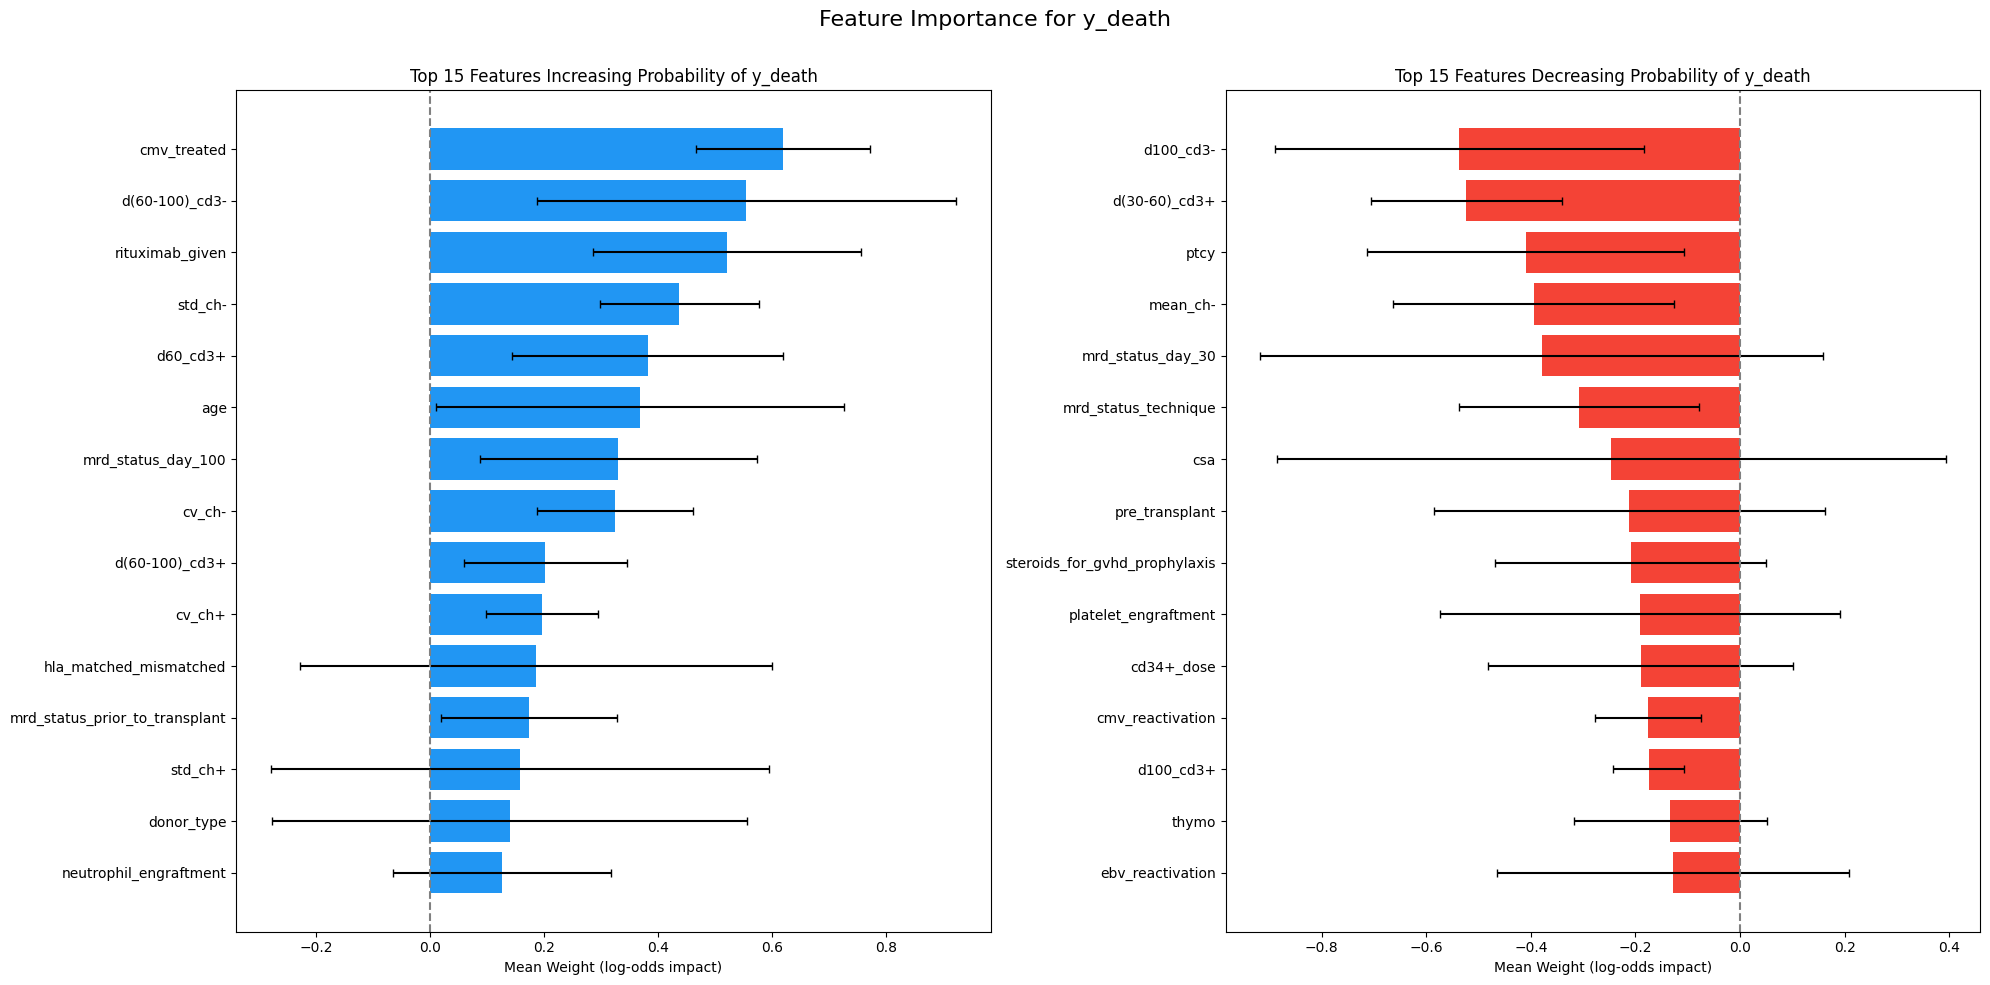


Top 10 most important features:
                               Feature  Mean Weight
cmv_treated                cmv_treated     0.618508
d(60-100)_cd3-          d(60-100)_cd3-     0.554990
rituximab_given        rituximab_given     0.520082
std_ch-                        std_ch-     0.437225
d60_cd3+                      d60_cd3+     0.381726
age                                age     0.368082
mrd_status_day_100  mrd_status_day_100     0.330194
cv_ch-                          cv_ch-     0.324415
d(60-100)_cd3+          d(60-100)_cd3+     0.202269
cv_ch+                          cv_ch+     0.196627

Top 10 least important features:
                                                     Feature  Mean Weight
platelet_engraftment                    platelet_engraftment    -0.190985
steroids_for_gvhd_prophylaxis  steroids_for_gvhd_prophylaxis    -0.208985
pre_transplant                                pre_transplant    -0.211897
csa                                                      csa    -

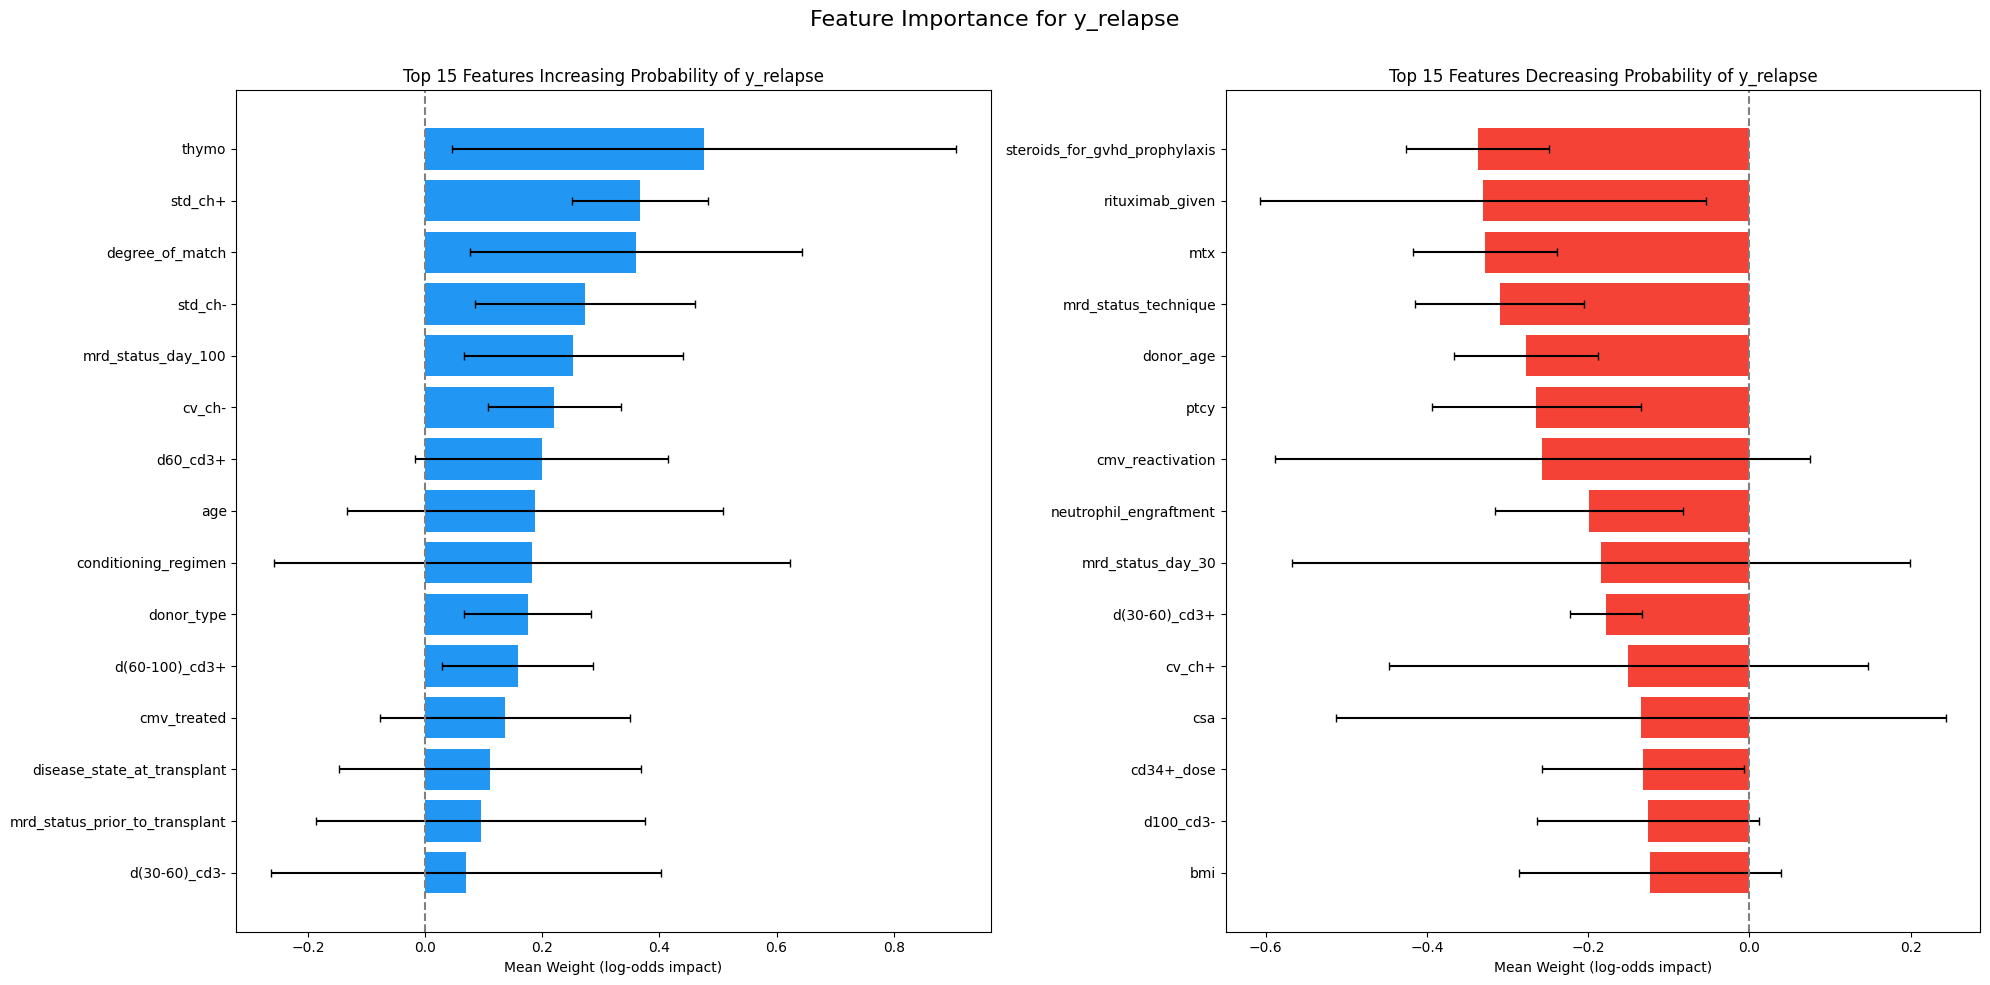


Top 10 most important features:
                                   Feature  Mean Weight
thymo                                thymo     0.476263
std_ch+                            std_ch+     0.367117
degree_of_match            degree_of_match     0.360077
std_ch-                            std_ch-     0.272498
mrd_status_day_100      mrd_status_day_100     0.252506
cv_ch-                              cv_ch-     0.220663
d60_cd3+                          d60_cd3+     0.198915
age                                    age     0.187578
conditioning_regimen  conditioning_regimen     0.181720
donor_type                      donor_type     0.174962

Top 10 least important features:
                                                     Feature  Mean Weight
d(30-60)_cd3+                                  d(30-60)_cd3+    -0.177766
mrd_status_day_30                          mrd_status_day_30    -0.184195
neutrophil_engraftment                neutrophil_engraftment    -0.198905
cmv_reactivation     

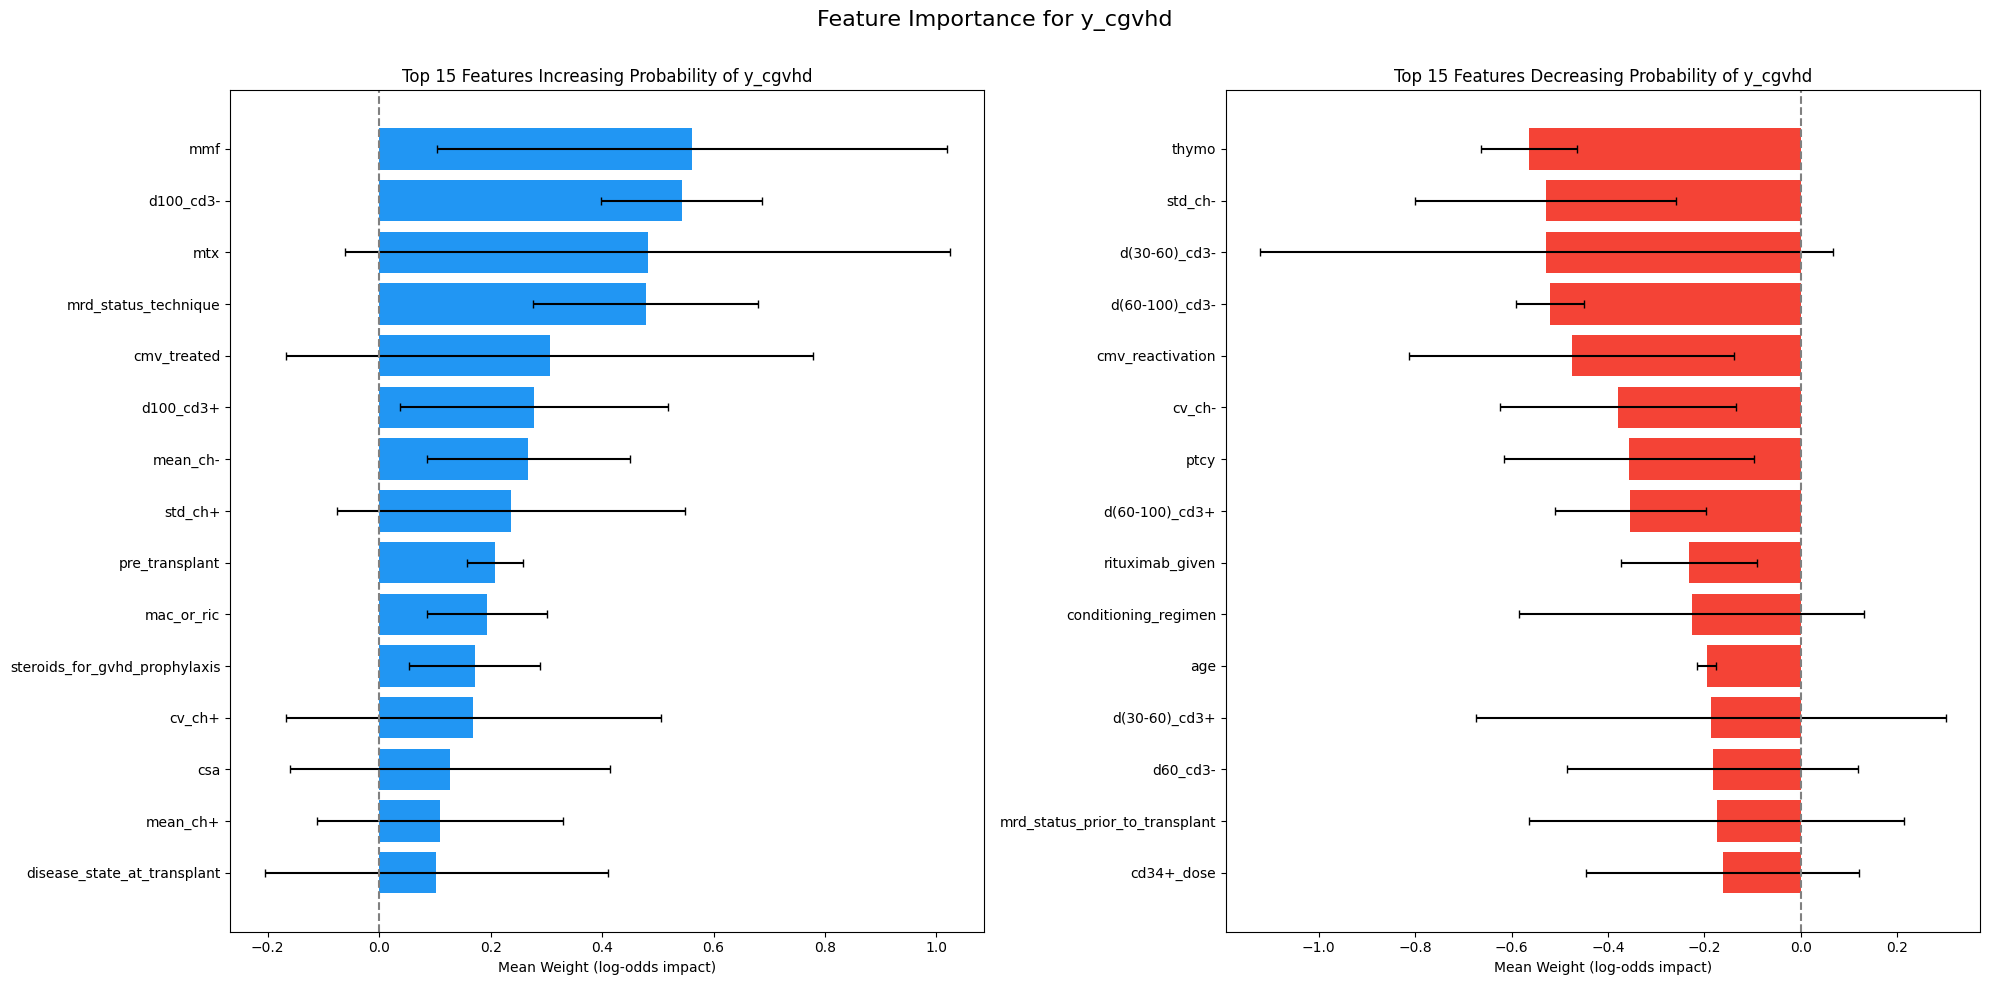


Top 10 most important features:
                                   Feature  Mean Weight
mmf                                    mmf     0.560624
d100_cd3-                        d100_cd3-     0.542668
mtx                                    mtx     0.481509
mrd_status_technique  mrd_status_technique     0.478049
cmv_treated                    cmv_treated     0.306100
d100_cd3+                        d100_cd3+     0.277879
mean_ch-                          mean_ch-     0.267599
std_ch+                            std_ch+     0.236163
pre_transplant              pre_transplant     0.207910
mac_or_ric                      mac_or_ric     0.193041

Top 10 least important features:
                                   Feature  Mean Weight
conditioning_regimen  conditioning_regimen    -0.226701
rituximab_given            rituximab_given    -0.231818
d(60-100)_cd3+              d(60-100)_cd3+    -0.354109
ptcy                                  ptcy    -0.356632
cv_ch-                              c

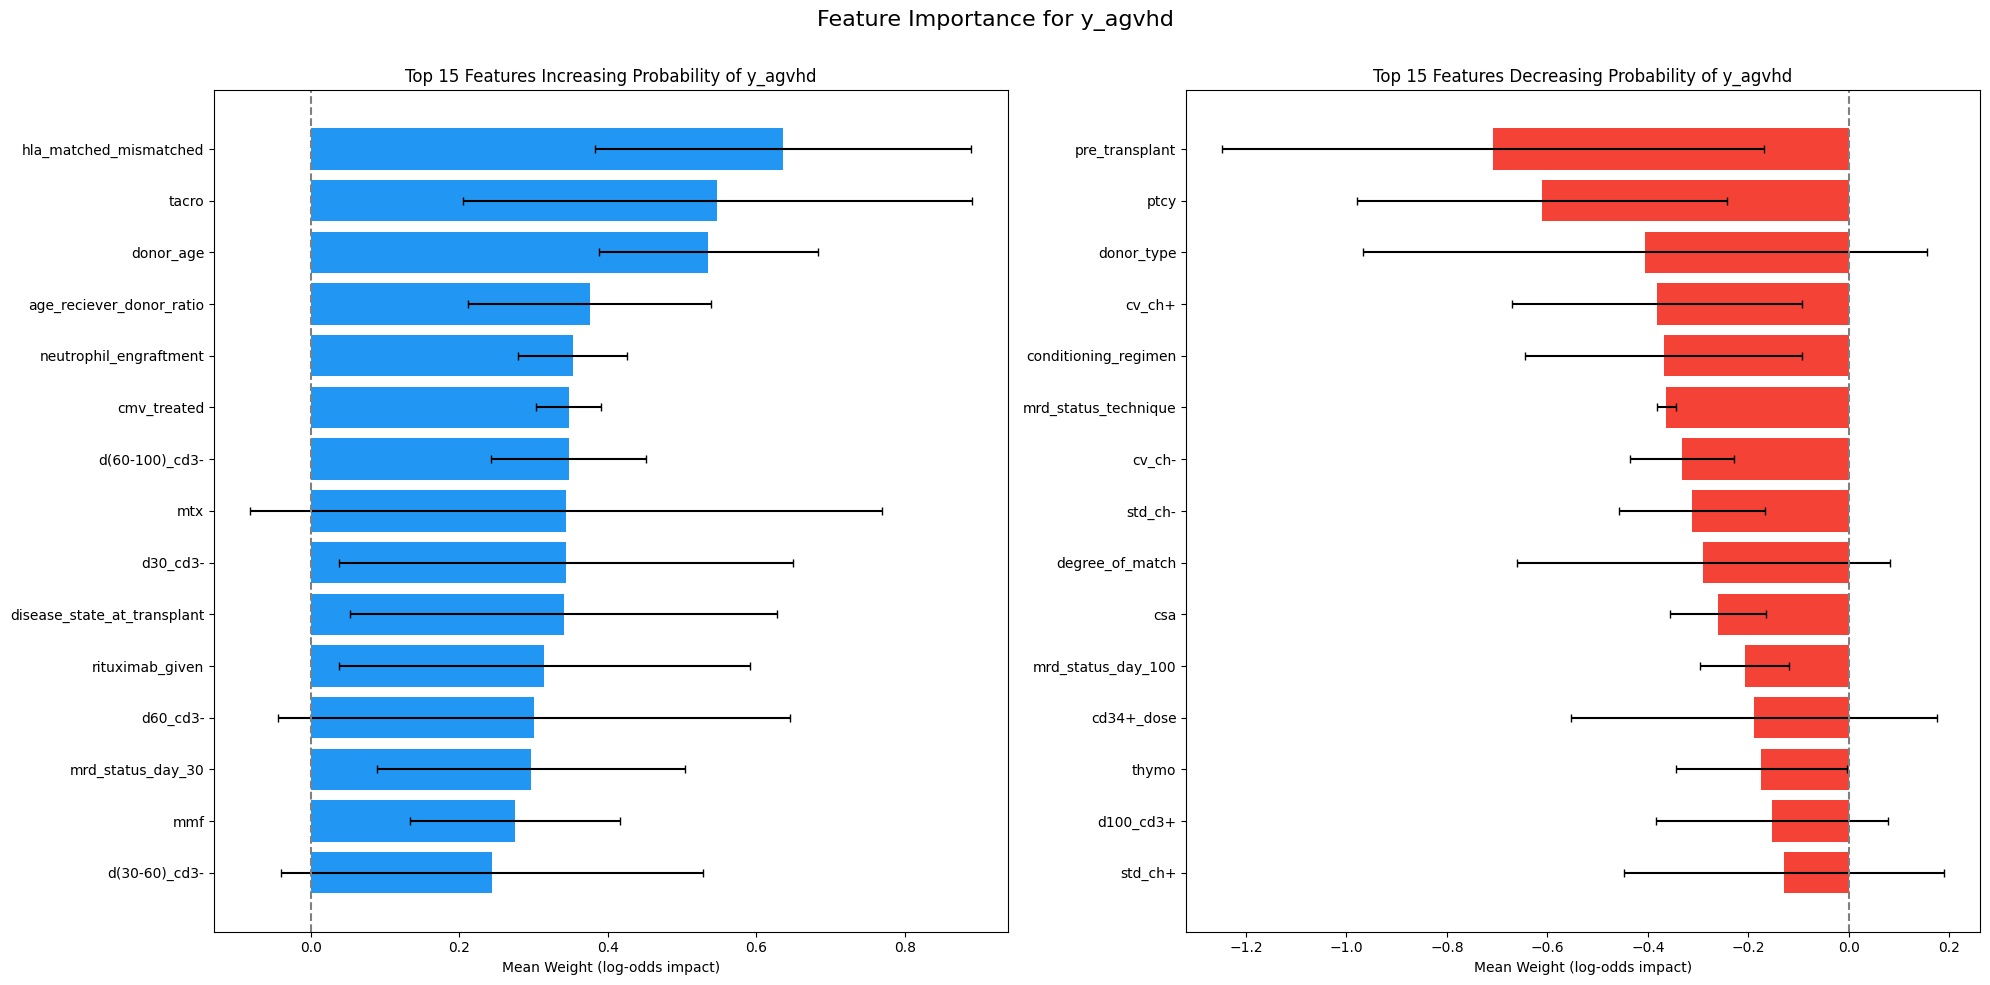


Top 10 most important features:
                                                 Feature  Mean Weight
hla_matched_mismatched            hla_matched_mismatched     0.636173
tacro                                              tacro     0.547546
donor_age                                      donor_age     0.535335
age_reciever_donor_ratio        age_reciever_donor_ratio     0.375624
neutrophil_engraftment            neutrophil_engraftment     0.352528
cmv_treated                                  cmv_treated     0.347197
d(60-100)_cd3-                            d(60-100)_cd3-     0.347087
mtx                                                  mtx     0.343870
d30_cd3-                                        d30_cd3-     0.343294
disease_state_at_transplant  disease_state_at_transplant     0.340407

Top 10 least important features:
                                   Feature  Mean Weight
csa                                    csa    -0.260873
degree_of_match            degree_of_match    -0.28

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize
X = X_preprocessed
features = X.columns
n_splits = 3

# Labels to analyze
labels = ['y_rfs', 'y_death', 'y_relapse', 'y_cgvhd', 'y_agvhd']

# Function to plot feature importance for a specific label
def plot_feature_importance(X, y, features, label_name, n_splits=3, top_n=15):
    # Create Stratified K-Folds
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    coefs = []
    
    # Loop through folds
    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        model = LogisticRegression(penalty='l2', max_iter=1000)
        model.fit(X_train_fold, y_train_fold)
        
        coefs.append(model.coef_[0])
    
    # Convert to DataFrame
    coef_matrix = pd.DataFrame(coefs, columns=features)
    coef_mean = coef_matrix.mean()
    coef_std = coef_matrix.std()
    
    # Create DataFrame for plotting
    coef_df = pd.DataFrame({
        'Feature': features,
        'Mean Weight': coef_mean,
        'Std Weight': coef_std
    }).sort_values(by='Mean Weight', ascending=False)
    
    # Separate increasing and decreasing features
    top_positive = coef_df[coef_df['Mean Weight'] > 0].head(top_n)
    top_negative = coef_df[coef_df['Mean Weight'] < 0].tail(top_n).iloc[::-1]  # Reverse to show most negative first
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot positive coefficients with error bars
    ax1.barh(top_positive['Feature'], top_positive['Mean Weight'], xerr=top_positive['Std Weight'], capsize=3, color='#2196F3')
    ax1.set_title(f'Top {top_n} Features Increasing Probability of {label_name}')
    ax1.set_xlabel('Mean Weight (log-odds impact)')
    ax1.invert_yaxis()
    ax1.axvline(0, color='gray', linestyle='--')
    
    # Plot negative coefficients with error bars
    ax2.barh(top_negative['Feature'], top_negative['Mean Weight'], xerr=top_negative['Std Weight'], capsize=3, color='#F44336')
    ax2.set_title(f'Top {top_n} Features Decreasing Probability of {label_name}')
    ax2.set_xlabel('Mean Weight (log-odds impact)')
    ax2.invert_yaxis()
    ax2.axvline(0, color='gray', linestyle='--')
    
    plt.suptitle(f'Feature Importance for {label_name}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    return coef_df

# Loop through each label and plot
for label_name in labels:
    print(f"\n\n{'='*50}")
    print(f"Analyzing label: {label_name}")
    print(f"{'='*50}")
    
    # Get the target variable
    y = y_classification[label_name]
    
    # Check class balance
    value_counts = y.value_counts()
    print(f"Class distribution: {dict(value_counts)}")
    
    # Plot feature importance
    coef_df = plot_feature_importance(X, y, features, label_name)
    
    # Optionally print top features for this label
    print("\nTop 10 most important features:")
    print(coef_df.iloc[:10][['Feature', 'Mean Weight']])
    print("\nTop 10 least important features:")
    print(coef_df.iloc[-10:][['Feature', 'Mean Weight']])